# Notebook for running Model in Google Colab

I used gemini AI to set up the outline of the notebook in google colab based off of the python scripts in /models. It was helpful in transfering things over to the colab runtime so I could use GPUs.

In [ ]:
import sys
import os
import random
import shutil
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight

# Google Colab Setup
from google.colab import drive

print("Running in Google Colab. Mounting Drive...")
drive.mount('/content/drive')

print('Mounted at /content/drive')

PROJECT_PATH = '/content/drive/MyDrive/188_2'

os.chdir(PROJECT_PATH)
print(f"Changed working directory to: {PROJECT_PATH}")

models_path = os.path.join(os.getcwd(), 'models')

print(f"Working Directory: {os.getcwd()}")
print(f"Models Path: {models_path}")

from preprocess import preprocess_subject_data, normalize_data, get_subject_indices
from model import ApneaCNNTransformer
print("Successfully imported models")

/usr/local/lib/python3.12/dist-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Running in Google Colab. Mounting Drive...
Mounted at /content/drive
Changed working directory to: /content/drive/MyDrive/188_2
Working Directory: /content/drive/MyDrive/188_2
Models Path: /content/drive/MyDrive/188_2/models
Successfully imported models


## Processing data and saving it using functions from preprocess.py

In [ ]:
DATA_DIR = 'data'
PROCESSED_DATA_DIR = 'processed_data'
RESULTS_DIR = 'model_results'

os.makedirs(PROCESSED_DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print("Loading raw data...")
train_raw = np.load(os.path.join(DATA_DIR, 'train_data_XL.npy'))
val_raw = np.load(os.path.join(DATA_DIR, 'val_data_XL.npy'))
test_raw = np.load(os.path.join(DATA_DIR, 'test_data_XL.npy'))

print("Extracting features and labels...")
X_train, y_train = preprocess_subject_data(train_raw)
X_val, y_val = preprocess_subject_data(val_raw)
X_test, y_test = preprocess_subject_data(test_raw)

print("Normalizing...")
X_train_norm, X_val_norm, X_test_norm = normalize_data(X_train, X_val, X_test)

train_subjects = get_subject_indices(train_raw.shape)
val_subjects = get_subject_indices(val_raw.shape)
test_subjects = get_subject_indices(test_raw.shape)

print("Saving processed data...")
np.save(os.path.join(PROCESSED_DATA_DIR, 'X_train.npy'), X_train_norm)
np.save(os.path.join(PROCESSED_DATA_DIR, 'y_train.npy'), y_train)
np.save(os.path.join(PROCESSED_DATA_DIR, 'train_subjects.npy'), train_subjects)
np.save(os.path.join(PROCESSED_DATA_DIR, 'X_val.npy'), X_val_norm)
np.save(os.path.join(PROCESSED_DATA_DIR, 'y_val.npy'), y_val)
np.save(os.path.join(PROCESSED_DATA_DIR, 'val_subjects.npy'), val_subjects)
np.save(os.path.join(PROCESSED_DATA_DIR, 'X_test.npy'), X_test_norm)
np.save(os.path.join(PROCESSED_DATA_DIR, 'y_test.npy'), y_test)
np.save(os.path.join(PROCESSED_DATA_DIR, 'test_subjects.npy'), test_subjects)

print(f"Data processing complete. Saved to {PROCESSED_DATA_DIR}")

Loading raw data...
Extracting features and labels...
Normalizing...
Saving processed data...
Data processing complete. Saved to processed_data


## Setting up model in notebook using ApneaCNNTransformer class

In [ ]:
# function for setting random seed for reproducibility and multiple runs
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# computing class weights
def compute_class_weights(y_train):
    classes = np.unique(y_train)
    weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = {int(cls): float(w) for cls, w in zip(classes, weights)}
    return class_weights

print("Computing class weights...")
class_weights = compute_class_weights(y_train)
print(f"Class weights: {class_weights}")

# based on create_model in train.py file. basically just copied it over.

def get_model():
    # Model parameters from train.py
    model = ApneaCNNTransformer(
        n_channels=4,
        sequence_length=3000,
        n_classes=2,
        d_model=64,
        num_heads=4,
        num_transformer_layers=1
    )

    model.build((None, 3000, 4))

    optimizer = keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    )
    return model

print("Model builder function defined.")

Computing class weights...
Class weights: {0: 0.5184877933159516, 1: 14.022435897435898}
Model builder function defined.


## Setting up an experiment loop to train the model 10 times using different random seeds to get best model

In [ ]:
# Configuration for multiple runs for best performance
NUM_RUNS = 10
SEEDS = [42 + i*111 for i in range(NUM_RUNS)] # Different seeds
best_val_accuracy = 0
best_seed = None
all_histories = {}

print(f"Starting experiment with {NUM_RUNS} runs...")

# uses functionality from train.py 
for seed in SEEDS:
    print(f"\n{'='*40}")
    print(f"Starting run with SEED {seed}")
    print(f"{'='*40}")

    set_seed(seed)

    # Get a fresh model
    model = get_model()

    # Unique checkpoint path for this seed
    checkpoint_path = os.path.join(RESULTS_DIR, f'best_model_seed_{seed}.keras')
     
    callbacks = [
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=0),
        keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-7, verbose=0),
        keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=0),
        keras.callbacks.TerminateOnNaN()
    ]

    print("Training...")
    history = model.fit(
        X_train_norm, y_train,
        validation_data=(X_val_norm, y_val),
        epochs=100,
        batch_size=32,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )

    all_histories[seed] = history.history

    # Determine best epoch performance based on validation accuracy
    best_epoch_idx = np.argmax(history.history['val_accuracy'])
    best_run_val_acc = history.history['val_accuracy'][best_epoch_idx]
    best_run_val_loss = history.history['val_loss'][best_epoch_idx]

    print(f"Run {seed} complete. Best Val Acc: {best_run_val_acc:.4f} (Loss: {best_run_val_loss:.4f})")

    if best_run_val_acc > best_val_accuracy:
        best_val_accuracy = best_run_val_acc
        best_seed = seed
        print(f"New best model found!")

print("\n" + "="*40)
print("EXPERIMENT COMPLETE")
print("="*40)
print(f"Best Seed: {best_seed}")
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Set the best model as the default 'best_model.keras' for the evaluation cell
if best_seed is not None:
    src = os.path.join(RESULTS_DIR, f'best_model_seed_{best_seed}.keras')
    dst = os.path.join(RESULTS_DIR, 'best_model.keras')
    shutil.copy(src, dst)
    print(f"Copied best model (seed {best_seed}) to {dst}")

    # Load the best model into memory for immediate use
    model = keras.models.load_model(dst, custom_objects={
        'ApneaCNNTransformer': ApneaCNNTransformer
    })

Starting experiment with 10 runs...

Starting run with SEED 42
Training...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8283 - loss: 0.7346 - val_accuracy: 0.8681 - val_loss: 0.2351 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9134 - loss: 0.3926 - val_accuracy: 0.9800 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9401 - loss: 0.2814 - val_accuracy: 0.9933 - val_loss: 0.0202 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9391 - loss: 0.2687 - val_accuracy: 0.9976 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9365 - loss: 0.2970 - val_accuracy: 0.9976 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9513 - loss: 0.2439 - val_accuracy: 0.9962 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9537 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Epoch 1/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8509 - loss: 0.7164 - val_accuracy: 0.9719 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9298 - loss: 0.3437 - val_accuracy: 0.9881 - val_loss: 0.0516 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9467 - loss: 0.2717 - val_accuracy: 0.9957 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9569 - loss: 0.1998 - val_accuracy: 0.9976 - val_loss: 0.0159 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9475 - loss: 0.2165 - val_accuracy: 0.9643 - val_loss: 0.0904 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9532 - loss: 0.2373 - val_accuracy: 0.9981 - val_loss: 0.0179 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9447 - 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8288 - loss: 0.6846 - val_accuracy: 0.9424 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9003 - loss: 0.3809 - val_accuracy: 0.9657 - val_loss: 0.0733 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9425 - loss: 0.2886 - val_accuracy: 0.9871 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9526 - loss: 0.2442 - val_accuracy: 0.9857 - val_loss: 0.0389 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9490 - loss: 0.2386 - val_accuracy: 0.9924 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9547 - loss: 0.2174 - val_accuracy: 0.9743 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9574 - loss: 0.1885

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_3', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8698 - loss: 0.7936 - val_accuracy: 0.9686 - val_loss: 0.1169 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9420 - loss: 0.3155 - val_accuracy: 0.9986 - val_loss: 0.0426 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9494 - loss: 0.3060 - val_accuracy: 0.9962 - val_loss: 0.0576 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9521 - loss: 0.2264 - val_accuracy: 0.9900 - val_loss: 0.0653 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9538 - loss: 0.1929 - val_accuracy: 0.9943 - val_loss: 0.0361 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9552 - loss: 0.2419 - val_accuracy: 0.9929 - val_loss: 0.0317 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9518 - loss: 0.2858

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_4', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8212 - loss: 0.7331 - val_accuracy: 0.8905 - val_loss: 0.2274 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9323 - loss: 0.3854 - val_accuracy: 0.9976 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9442 - loss: 0.3278 - val_accuracy: 0.9871 - val_loss: 0.0308 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9393 - loss: 0.2742 - val_accuracy: 0.9976 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9454 - loss: 0.2414 - val_accuracy: 0.9919 - val_loss: 0.0208 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9563 - loss: 0.1828 - val_accuracy: 0.8981 - val_loss: 0.2580 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9519 - loss: 0.2522

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_5', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8252 - loss: 0.6171 - val_accuracy: 0.9919 - val_loss: 0.0898 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9152 - loss: 0.3501 - val_accuracy: 0.9976 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9433 - loss: 0.2723 - val_accuracy: 0.9943 - val_loss: 0.0176 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9341 - loss: 0.2618 - val_accuracy: 0.9962 - val_loss: 0.0180 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9487 - loss: 0.2847 - val_accuracy: 0.9971 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9466 - loss: 0.2453 - val_accuracy: 0.9981 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9514 - loss: 0.2666

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_6', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step - accuracy: 0.8486 - loss: 0.5408 - val_accuracy: 0.9638 - val_loss: 0.1089 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9378 - loss: 0.3101 - val_accuracy: 0.9919 - val_loss: 0.0472 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9497 - loss: 0.2623 - val_accuracy: 0.9895 - val_loss: 0.0330 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9579 - loss: 0.2210 - val_accuracy: 0.8595 - val_loss: 0.3868 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9604 - loss: 0.2244 - val_accuracy: 0.9676 - val_loss: 0.0967 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9571 - loss: 0.2061 - val_accuracy: 0.9919 - val_loss: 0.0358 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9534 - loss: 0.2093

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_7', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8516 - loss: 0.5969 - val_accuracy: 0.9810 - val_loss: 0.0643 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9267 - loss: 0.3941 - val_accuracy: 0.9962 - val_loss: 0.0246 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9460 - loss: 0.2991 - val_accuracy: 0.9976 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9576 - loss: 0.2323 - val_accuracy: 0.9971 - val_loss: 0.0144 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9573 - loss: 0.2143 - val_accuracy: 0.9867 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9639 - loss: 0.2029 - val_accuracy: 0.9281 - val_loss: 0.1668 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9593 - loss: 0.1869

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.7888 - loss: 0.6203 - val_accuracy: 0.8362 - val_loss: 0.3792 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9163 - loss: 0.3310 - val_accuracy: 0.9710 - val_loss: 0.1397 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9430 - loss: 0.3020 - val_accuracy: 0.9924 - val_loss: 0.0506 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9459 - loss: 0.2773 - val_accuracy: 0.9752 - val_loss: 0.0920 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9430 - loss: 0.3790 - val_accuracy: 0.6519 - val_loss: 0.6730 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9534 - loss: 0.2529 - val_accuracy: 0.8224 - val_loss: 0.3100 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9596 - loss: 0.2509

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'apnea_cnn_transformer_9', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


274/274 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.8592 - loss: 0.7549 - val_accuracy: 0.9976 - val_loss: 0.0573 - learning_rate: 0.0010
Epoch 2/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9302 - loss: 0.3280 - val_accuracy: 0.9938 - val_loss: 0.0699 - learning_rate: 0.0010
Epoch 3/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9469 - loss: 0.2506 - val_accuracy: 0.9810 - val_loss: 0.0884 - learning_rate: 0.0010
Epoch 4/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9530 - loss: 0.2820 - val_accuracy: 0.9914 - val_loss: 0.0239 - learning_rate: 0.0010
Epoch 5/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9627 - loss: 0.1945 - val_accuracy: 0.9967 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 6/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9551 - loss: 0.2259 - val_accuracy: 0.9976 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 7/100
274/274 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9578 - loss: 0.2041

Successfully imported visualization functions
Loaded best model from disk.
Evaluating on Test Set...
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step

Classification Report (computed metrics):
Accuracy: 0.7806
Recall: 0.5238
Precision: 0.0570
F1 Score: 0.1028
AUC ROC: 0.8065
Confusion Matrix saved to model_results/confusion_matrix.png


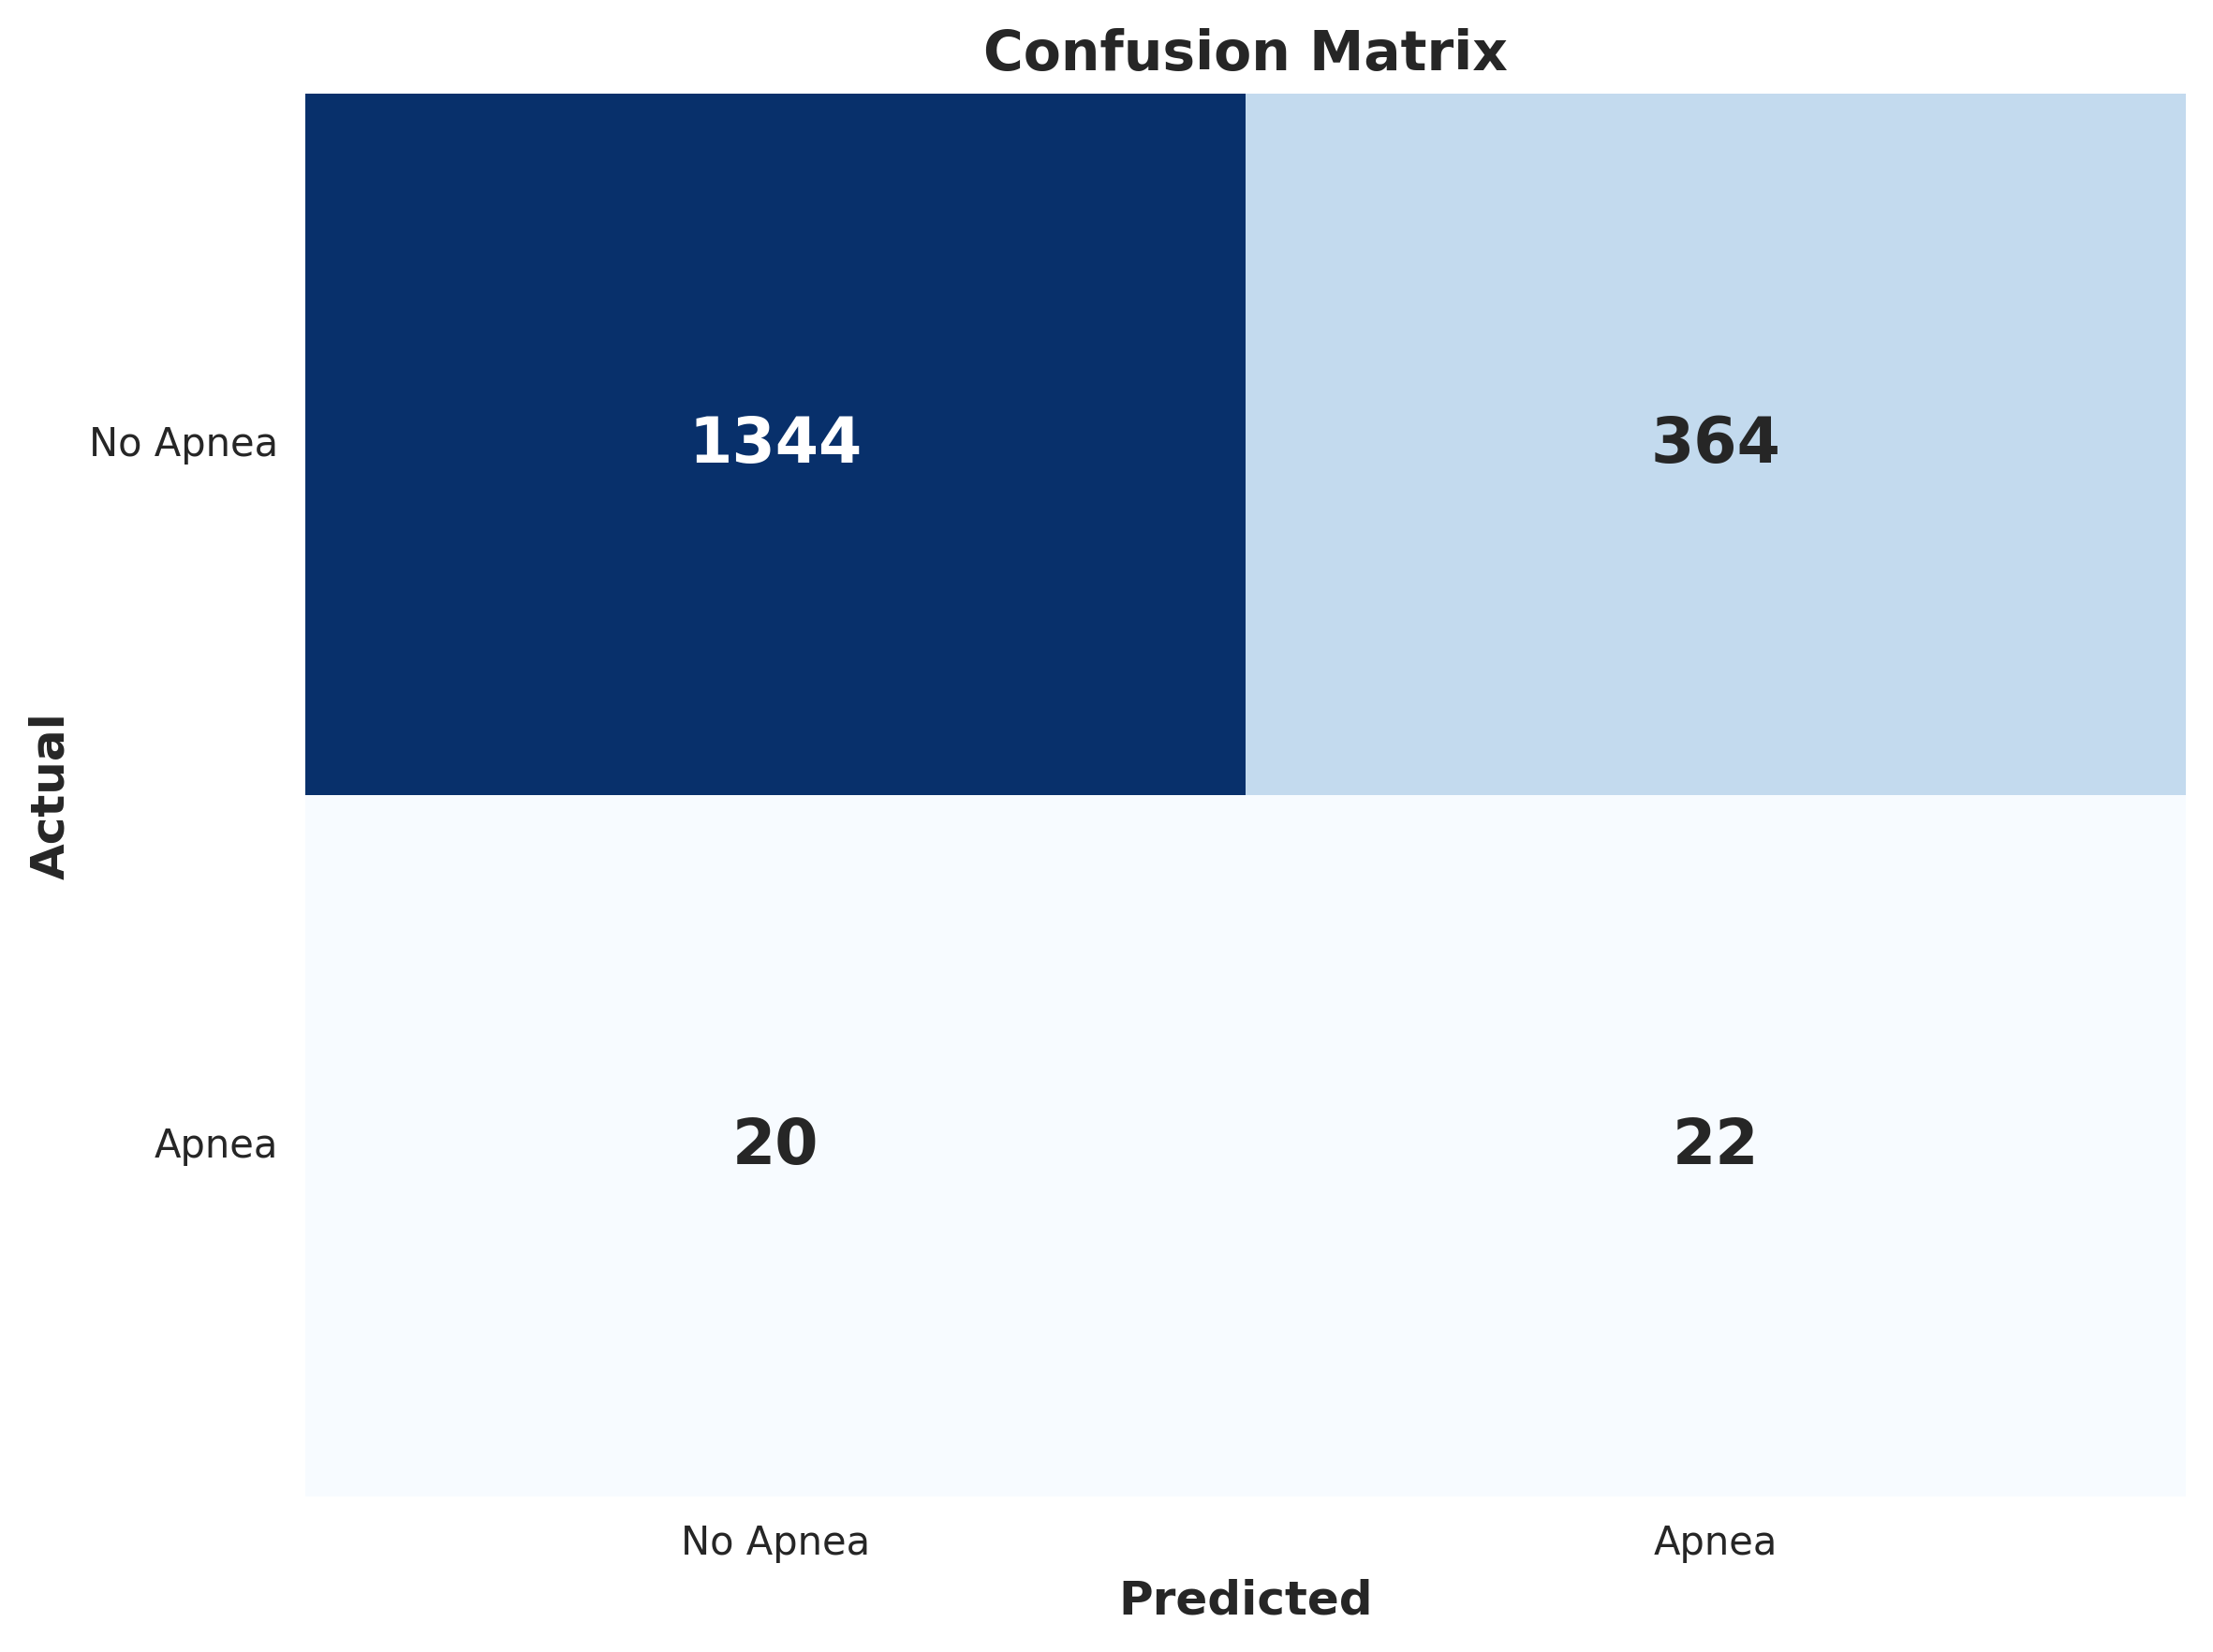

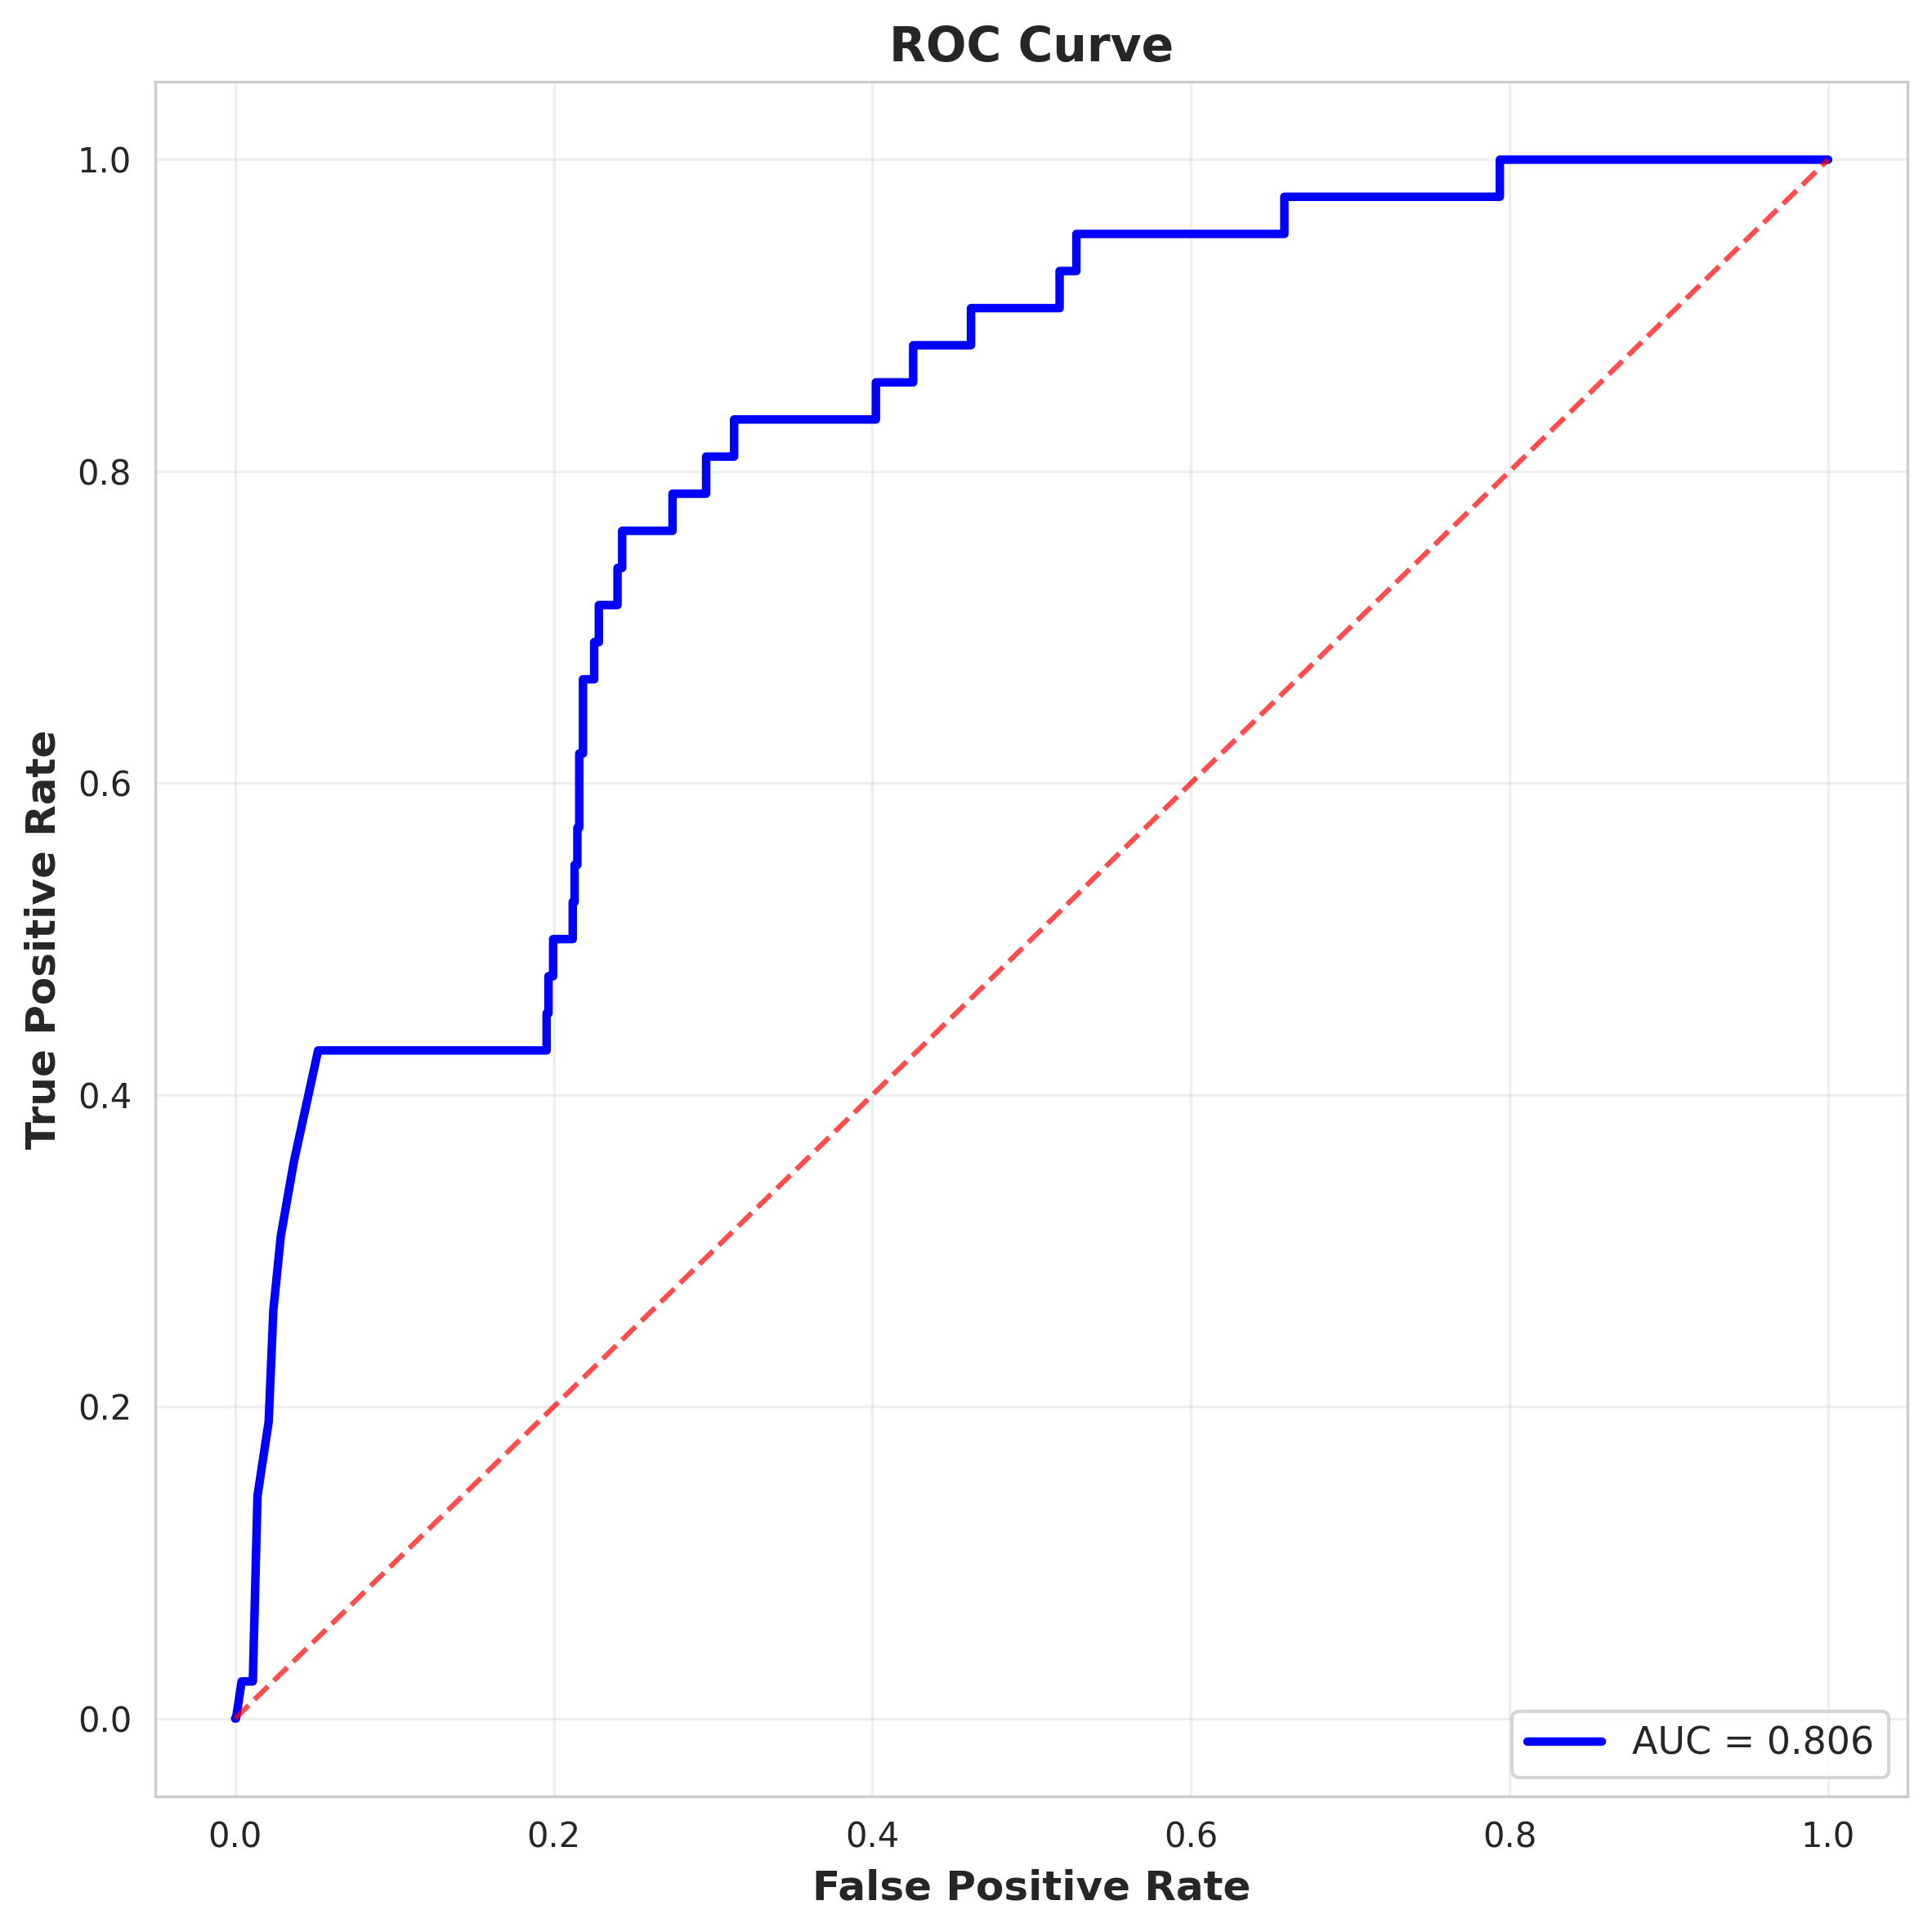

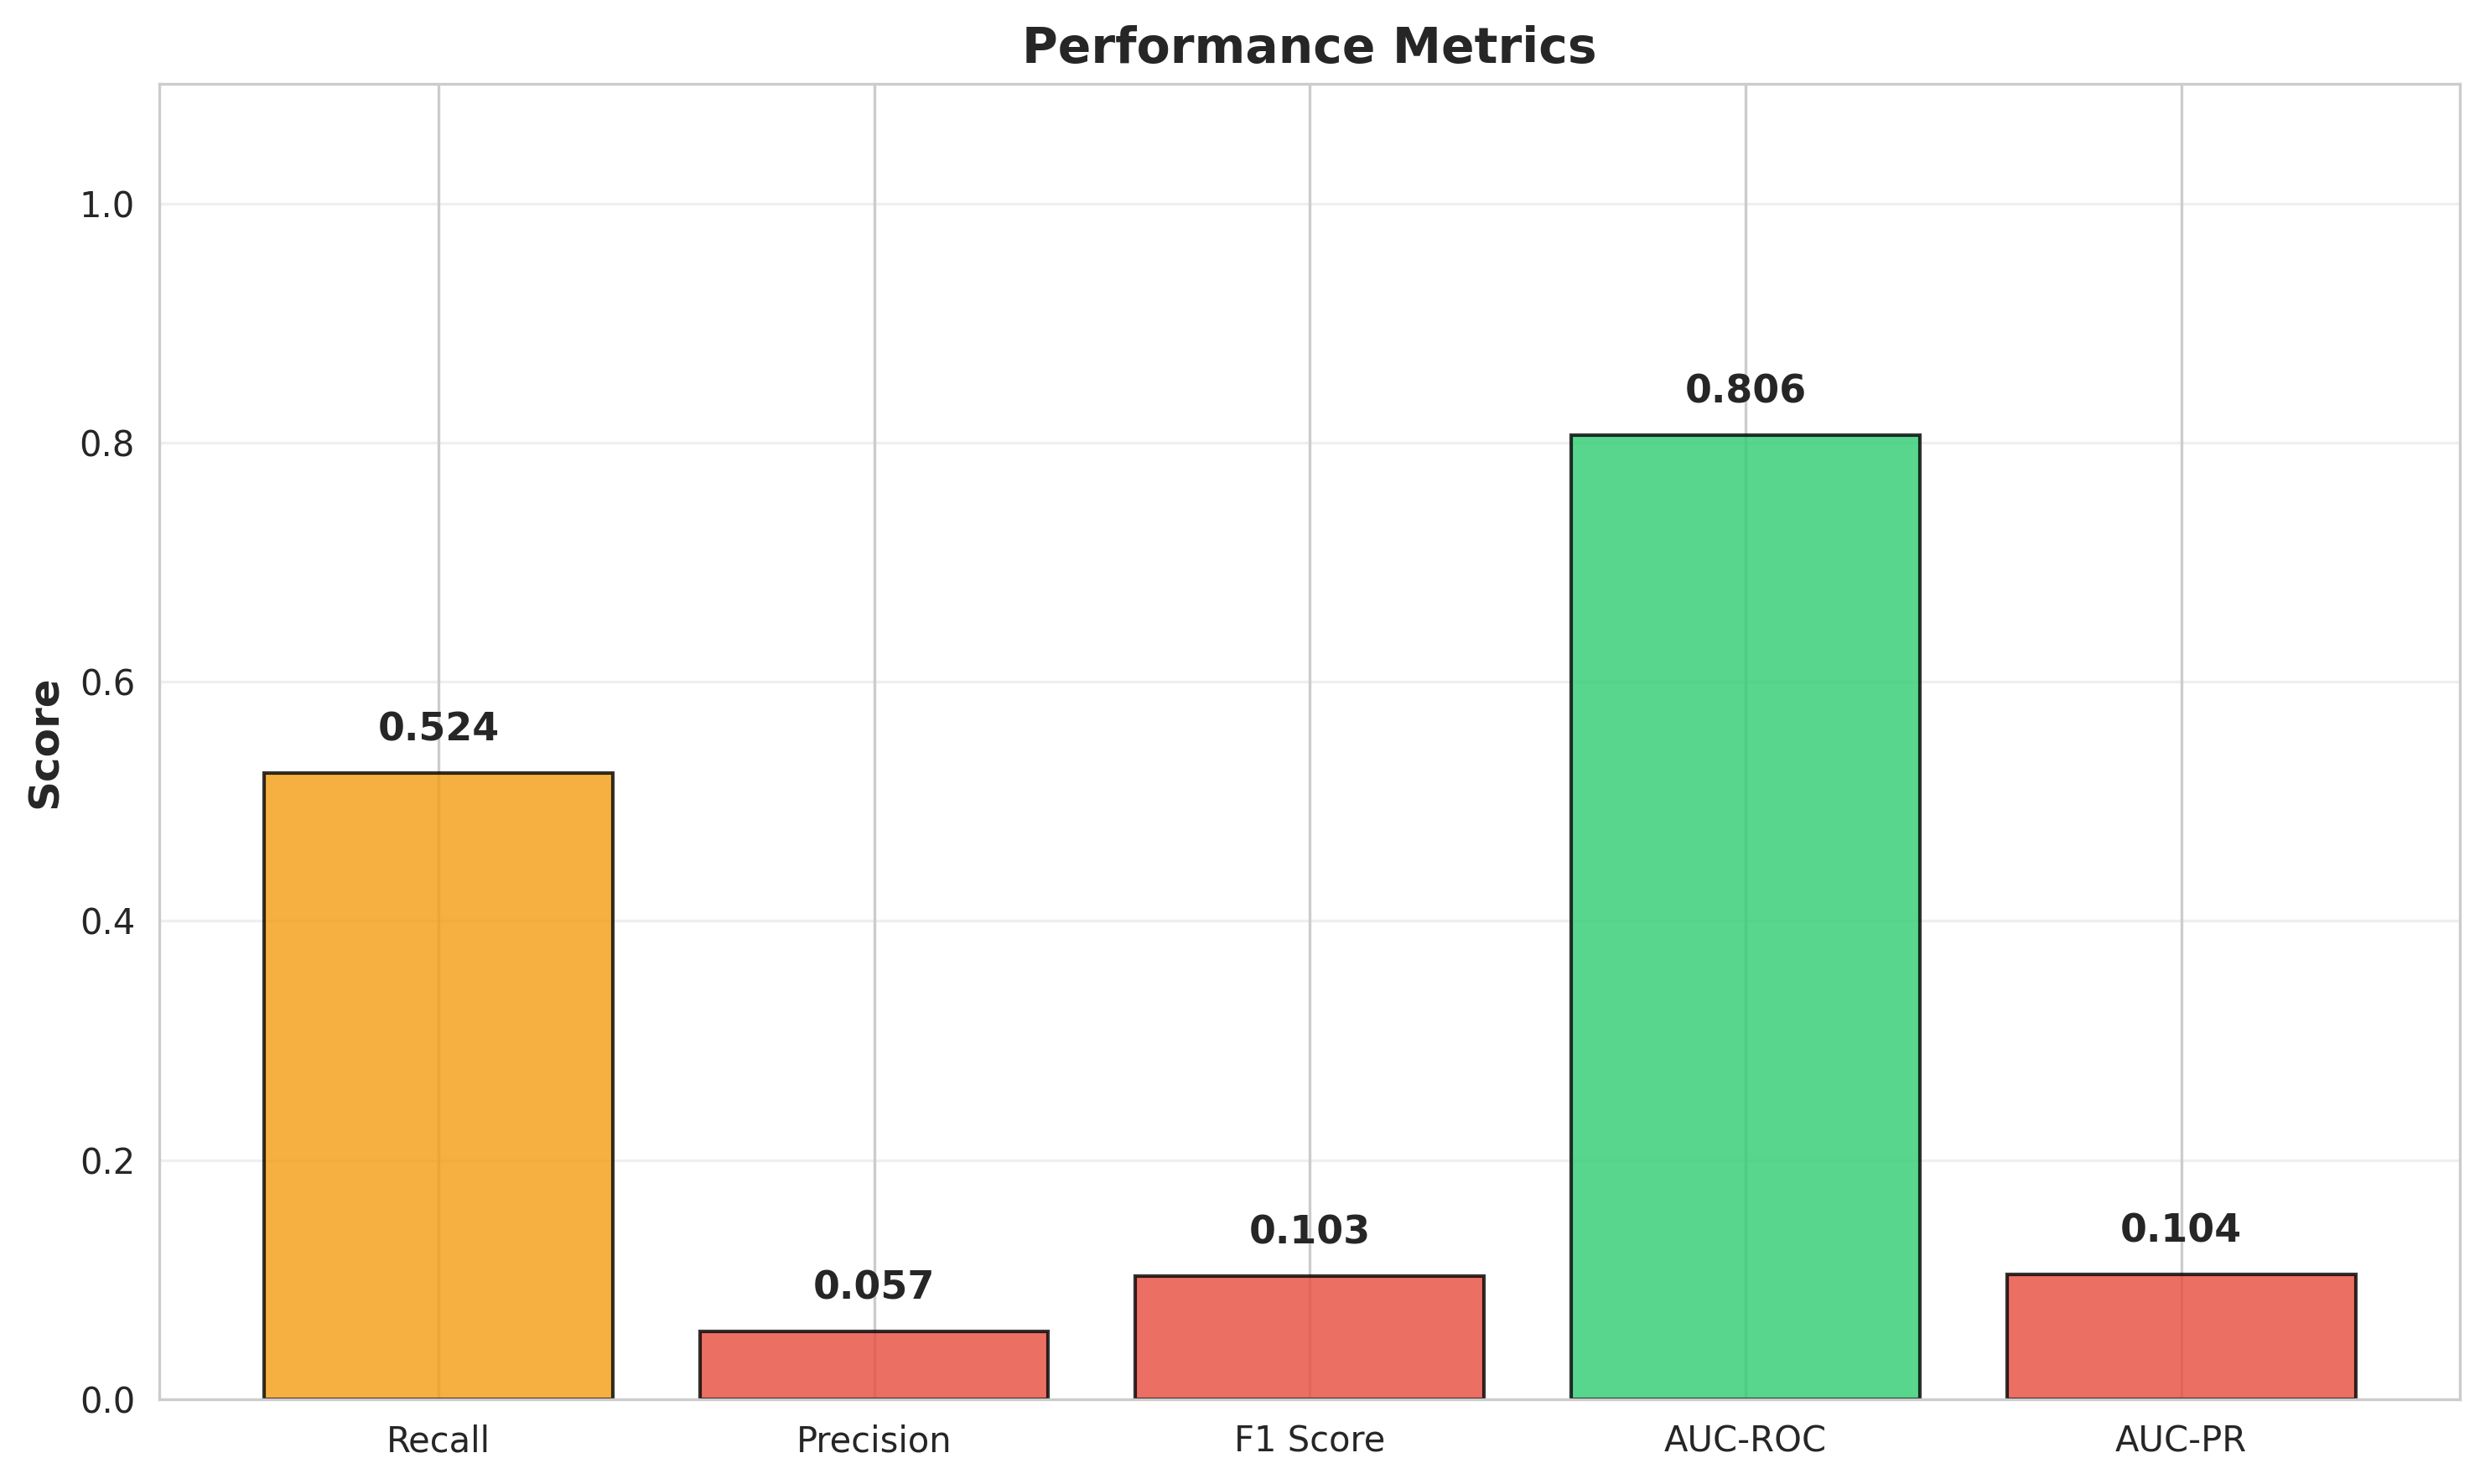

In [ ]:
from visualize import compute_metrics, plot_confusion_matrix, plot_metrics_summary, plot_roc_curve
print("Successfully imported visualization functions")

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from IPython.display import Image, display

# Load the best model
best_model_path = os.path.join(RESULTS_DIR, 'best_model.keras')
loaded_model = keras.models.load_model(best_model_path, custom_objects={
    'ApneaCNNTransformer': ApneaCNNTransformer,
    'PositionalEncoding': keras.layers.Layer,
})
print("Loaded best model from disk.")

print("Evaluating on Test Set...")
# Get probabilities
y_prob = loaded_model.predict(X_test_norm)
# Get class predictions
y_pred = np.argmax(y_prob, axis=1)

# Compute metrics using visualize.py function
metrics = compute_metrics(y_test, y_pred, y_prob)

print("\nClassification Report (computed metrics):")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Recall: {metrics['recall']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"F1 Score: {metrics['f1']:.4f}")
print(f"AUC ROC: {metrics['auc_roc']:.4f}")

# Plotting

# Confusion matrix
plot_path_cm = os.path.join(RESULTS_DIR, 'confusion_matrix.png')
plot_confusion_matrix(metrics['cm'], plot_path_cm)
print(f"Confusion Matrix saved to {plot_path_cm}")
display(Image(filename=plot_path_cm))

# ROC Curve
plot_path_roc = os.path.join(RESULTS_DIR, 'roc_curve.png')
plot_roc_curve(metrics, plot_path_roc)
display(Image(filename=plot_path_roc))

# Metrics Summary
plot_path_summary = os.path.join(RESULTS_DIR, 'metrics_summary.png')
plot_metrics_summary(metrics, plot_path_summary)
display(Image(filename=plot_path_summary))